<a href="https://colab.research.google.com/github/ShawnDong98/GAN/blob/master/VAE/VAE_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
%matplotlib inline
import argparse
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

In [2]:
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=100, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--n_gpu", type=int, default=1, help="number of gpu")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--ngf", type=int, default=64, help="numbers of generator's features")
parser.add_argument("--ndf", type=int, default=64, help="numbers of discriminator's features")
parser.add_argument("--img_size", type=int, default=64, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=3, help="number of image channels")
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args = parser.parse_known_args()[0]
args.cuda = True if torch.cuda.is_available() else False
print(args)

#Sets the seed for generating random numbers. And returns a torch._C.Generator object.
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)  

Namespace(batch_size=64, channels=3, cuda=True, epochs=100, img_size=64, latent_dim=100, log_interval=10, n_cpu=8, n_gpu=1, ndf=64, ngf=64, seed=1)


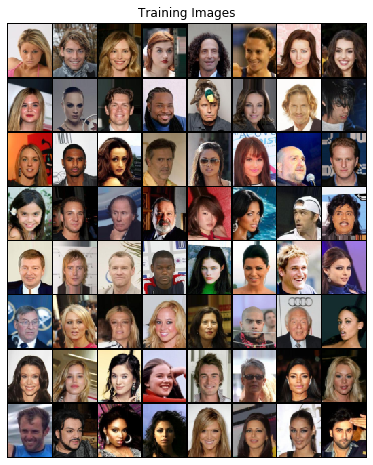

In [3]:
kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
trainset = datasets.ImageFolder('../data/celeba/', 
                                transform=transforms.Compose(
            [transforms.Resize(args.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
                ),
            )
train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=args.batch_size, shuffle=True, **kwargs)

real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].cuda()[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
                nn.Conv2d(args.channels, 64, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.2, inplace=True),
            
                nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(0.2, inplace=True),
            
                nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(0.2, inplace=True),
                )
        
        self.fc11 = nn.Linear(128 * 16 * 16, args.latent_dim)
        self.fc12 = nn.Linear(128 * 16 * 16, args.latent_dim)
        self.fc2 = nn.Linear(args.latent_dim, 128 * 16 * 16)
        
        self.decoder = nn.Sequential(
                nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
                nn.ReLU(inplace=True),
            
                nn.ConvTranspose2d(64, args.channels, kernel_size=4, stride=2, padding=1),
                nn.Sigmoid()
                )
        
    def reparameterize(self, mu, logvar):
        eps = Variable(torch.randn(mu.size(0), mu.size(1))).cuda()
        z = mu + eps * torch.exp(logvar/2)
        
        return z
    
    def forward(self, x):
        out1, out2 = self.encoder(x), self.encoder(x)
        mu = self.fc11(out1.view(out1.size(0), -1))
        logvar = self.fc12(out2.view(out2.size(0), -1))
        z = self.reparameterize(mu, logvar)
        out3 = self.fc2(z).view(z.size(0), 128, 16, 16)
        
        return self.decoder(out3), mu, logvar

In [5]:
reconstruction_function = nn.BCELoss()
reconstruction_function.size_average = False

def loss_function(recon_x, x, mu, logvar):
    BCE = reconstruction_function(recon_x, x)
    #BCE = F.binary_cross_entropy(recon_x, x,  size_average=False)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return BCE + KLD

vae = VAE()
if args.cuda:
    vae.cuda()
    
optimizer =  optim.Adam(vae.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [6]:
def train(EPOTCH):
    vae.train()
    total_loss = 0
    for i, (data, _) in enumerate(train_loader, 0):
        
        data = Variable(data).cuda()
        data = data.resize_(data.shape[0], args.channels, args.img_size,  args.img_size)
       
        optimizer.zero_grad()
        recon_x, mu, logvar = vae.forward(data)
        loss = loss_function(recon_x, data, mu, logvar)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
        
        if i % args.log_interval == 0:
            sample = Variable(torch.randn(64, args.latent_dim)).cuda()
            sample = vae.decoder(vae.fc2(sample).view(64, 128, 16, 16)).cpu()
            save_image(sample.data.view(64, 3, 64, 64),
                       'result/' + str(epoch) + '.png')
            print('Train Epoch:{} -- [{}/{} ({:.0f}%)] -- Loss:{:.6f}'.format(
                epoch, i*len(data), len(train_loader.dataset), 
                100.*i/len(train_loader), loss.item()/len(data)))
            
#         print('====> Epoch: {} Average loss: {:.4f}'.format(
#             epoch, total_loss / len(train_loader.dataset)))

In [ ]:
for epoch in range(1, args.epochs + 1):
    train(epoch)